In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr

from easydict import EasyDict as edict
from collections import defaultdict as ddict
from tqdm import trange, tqdm
from scipy.io import loadmat

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
from utils.misc import save_pkl, load_pkl
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from splines import obt_bsp_basis_Rfn

## Parameters and fns

### Params

In [4]:
_paras = edict()
_paras.res_dir = RES_ROOT/"linear_tuningN2"

### Fn

In [5]:
def _filename2paras(p):
    """Get the parameters (lam, Rfct, n) based on filename
    """
    sep_p = p.stem.split("_")
    res = edict()
    assert sep_p[1].startswith("lam")
    assert sep_p[2].startswith("Rfct")
    if len(sep_p) == 4:
        assert sep_p[3].startswith("n")
        n_v = int(sep_p[3].split("-")[-1])
        res.n = n_v
    elif len(sep_p) == 5:
        assert sep_p[3].startswith("N")
        assert sep_p[4].startswith("n")
        N_v = int(sep_p[3].split("-")[-1])
        n_v = int(sep_p[4].split("-")[-1])
        res.N = N_v
        res.n = n_v
    lam_v = int(sep_p[1].split("-")[-1])/100
    Rfct_v = int(sep_p[2].split("-")[-1])/10
    
    res.lam = lam_v
    res.Rfct = Rfct_v
    return res

In [6]:
def _res2err(opt, paras):
    """The fn to return the error"""
    errs = edict()
    alp_est = opt.thetak[:paras.q].numpy()
    gam_est = opt.Gamk.numpy()
    beta_est = paras.bsp.basis_mat @ gam_est
    
    beta_diff = np.asarray(beta_est - paras.beta_GT)
    alp_diff = alp_est - paras.alp_GT
        
    beta_est_l0 = np.linalg.norm(beta_est, axis=0)[paras.sel_idx] == 0
    beta_gt_l0 = np.linalg.norm(paras.beta_GT, axis=0)[paras.sel_idx] == 0
    errs.beta_err_l0 = np.bitwise_xor(beta_est_l0, beta_gt_l0).sum()
    errs.beta_err_l0_neg = (beta_gt_l0.astype(int) -  beta_est_l0.astype(int))[np.bitwise_not(beta_gt_l0)].sum()
        
    errs.beta_err_l1 = np.abs(beta_diff).sum()
    errs.beta_err_l2 = np.linalg.norm(beta_diff)
        
    errs.alp_err_l1 = np.abs(alp_diff).sum()
    errs.alp_err_l2 = np.linalg.norm(alp_diff)
        
    beta_loss_fnl1 = np.mean(np.abs(beta_diff), axis=0)
    beta_loss_fnl2 = np.sqrt(np.mean(beta_diff**2, axis=0))
    errs.beta_err_l1 = beta_loss_fnl1.sum()
    errs.beta_err_l2 = np.linalg.norm(beta_loss_fnl2)
    return errs

## Load data

## Analysis-sampe-wise

In [47]:
cur_n = 8100
fils = list(_paras.res_dir.glob(f"result_*n-{cur_n}*.pkl"))
sorted_fils = sorted(fils, key=lambda x: _filename2paras(x).lam*10000+_filename2paras(x).N*1)
paras = load_pkl(_paras.res_dir/f"paras_{cur_n}.pkl")
paras.keys()

dict_keys(['model', 'num_rep', 'n', 'ns', 'npts', 'd', 'q', 'sigma2', 'sel_idx', 'stop_cv', 'max_iter', 'can_lams', 'can_Rfcts', 'can_Ns', 'bsp', 'types_', 'alp_GT', 'beta_GT', 'Gam_est', 'Rmin', 'save_dir'])

In [25]:
# load file first to save time
resss = []
for cur_fil in tqdm(sorted_fils):
    ress = load_pkl(cur_fil)
    resss.append(ress)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 36.77it/s]


In [26]:
err_mats = ddict(lambda : np.zeros((paras.num_rep, len(paras.can_lams), len(paras.can_Ns))))
for ix, cur_fil in enumerate(sorted_fils):
    cur_para = _filename2paras(cur_fil)
    
    row_idx = paras.can_lams.index(cur_para.lam)
    col_idx = paras.can_Ns.index(cur_para.N)
    #col_idx = paras.can_Rfcts.index(cur_para.Rfct)
    
    
    ress = resss[ix]
    errs = []
    paras.bsp.N = cur_para.N
    paras.bsp.x = np.linspace(0, 1, paras.npts)
    paras.bsp.aknots_raw = np.linspace(0, 1, paras.bsp.N-2)
    paras.bsp.iknots = paras.bsp.aknots_raw[1:-1]
    paras.bsp.bknots = np.array([0, 1])
    paras.bsp.basis_mat = obt_bsp_basis_Rfn(paras.bsp.x, 
                                        paras.bsp.iknots, 
                                        paras.bsp.bknots, 
                                        paras.bsp.ord)
    paras.Gam_est = (np.linalg.inv(paras.bsp.basis_mat.T 
                                   @ paras.bsp.basis_mat) 
                     @ paras.bsp.basis_mat.T 
                     @ paras.beta_GT)
    for cur_res in ress:
        if not cur_res[1]:
            err =_res2err(cur_res[0], paras)
            errs.append(err)
            
    for key in err.keys():
        #sel_err = np.mean([cur_err[key]
        #                   for cur_err in errs])
        sel_err = np.array([cur_err[key] for cur_err in errs])
        err_mats[key][:, row_idx, col_idx] = sel_err
err_mats = edict(err_mats)
save_pkl(_paras.res_dir/f"err_mats_{cur_n}.pkl", err_mats, 1)

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/linear_tuningN2/err_mats_8100.pkl


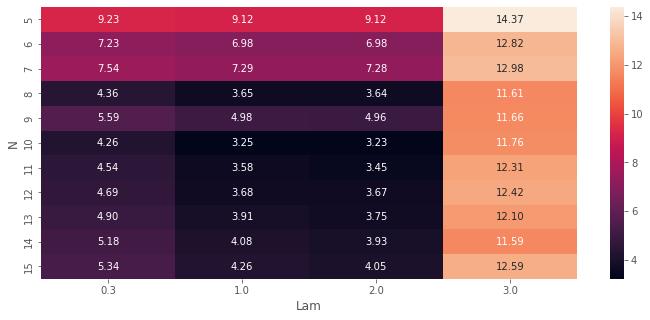

In [27]:
plt.figure(figsize=[12, 5])
cur_mat = err_mats.beta_err_l2.mean(axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cur_mat.T, 3), square=0, fmt=".2f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns)
plt.xticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);
plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

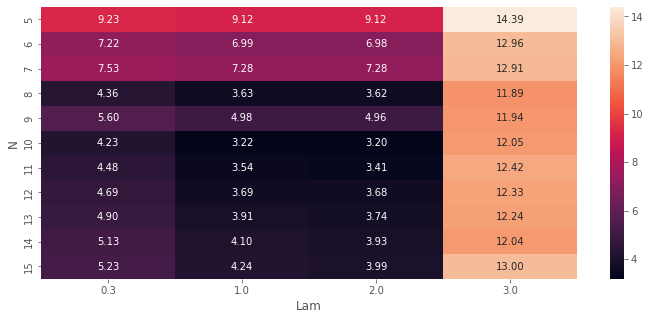

In [23]:
plt.figure(figsize=[12, 5])
cur_mat = err_mats.beta_err_l2.mean(axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cur_mat.T, 3), square=0, fmt=".2f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns)
plt.xticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);
plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

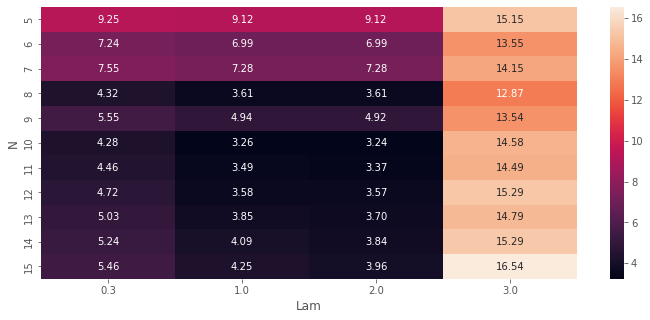

In [19]:
plt.figure(figsize=[12, 5])
cur_mat = err_mats.beta_err_l2.mean(axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cur_mat.T, 3), square=0, fmt=".2f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns)
plt.xticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);
plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

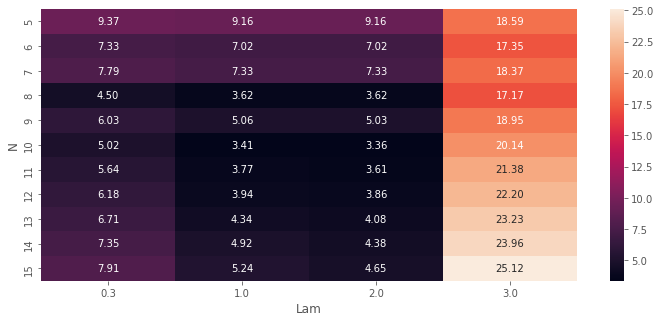

In [15]:
plt.figure(figsize=[12, 5])
cur_mat = err_mats.beta_err_l2.mean(axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cur_mat.T, 3), square=0, fmt=".2f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns)
plt.xticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);
plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

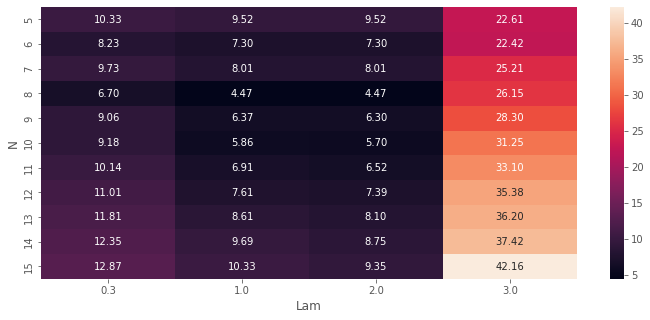

In [11]:
plt.figure(figsize=[12, 5])
cur_mat = err_mats.beta_err_l2.mean(axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cur_mat.T, 3), square=0, fmt=".2f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns)
plt.xticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);
plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

## The beta curve

In [46]:
cur_n = 8100
cur_lam = 2
cur_fil = list(_paras.res_dir.glob(f"result_*lam-{cur_lam*100:.0f}_Rfct-20_n-{cur_n}*.pkl"))[0]
paras = load_pkl(_paras.res_dir/f"paras_{cur_n}.pkl")
cur_ress = load_pkl(cur_fil)

IndexError: list index out of range

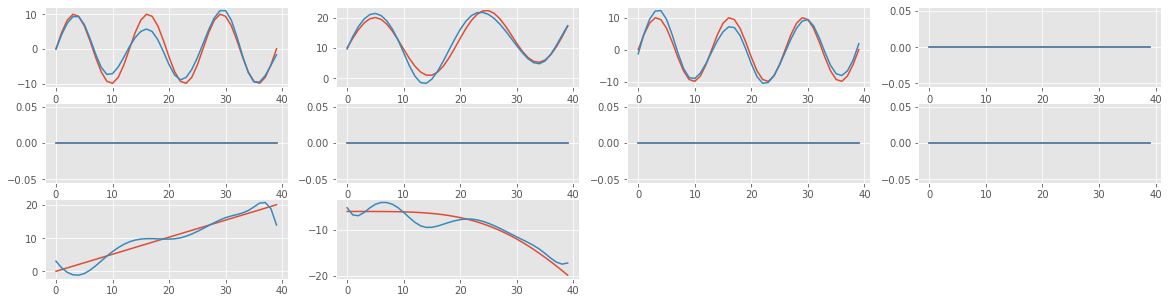

In [32]:
opt = cur_ress[2][0]
beta_est = paras.bsp.basis_mat @ opt.Gamk.numpy()
plt.figure(figsize=[20, 5])
for ix, roi_id in enumerate(list(range(10))):
    plt.subplot(3, 4, ix+1)
    plt.plot(paras.beta_GT[:, roi_id])
    plt.plot(beta_est[:, roi_id])

## Analysis-all

In [28]:
fils = list(_paras.res_dir.glob(f"err_mats_*.pkl"))
sorted_fils = sorted(fils, key=lambda x:int(x.stem.split("_")[-1]))

Text(0.5, 0, 'Sample size')

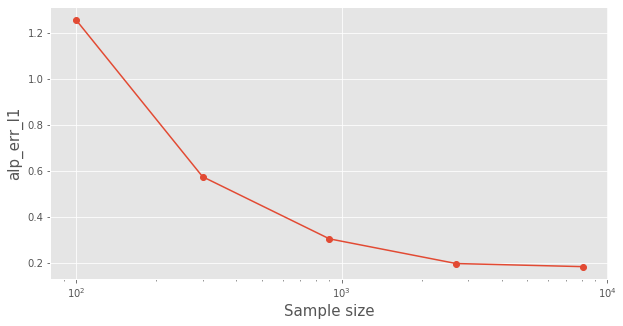

In [45]:
# errtypes are 
#['beta_err_l0', 'beta_err_l0_neg',
# 'beta_err_l1', 'beta_err_l2', 
#'alp_err_l1', 'alp_err_l2', 
err_type = "alp_err_l1"
ns = []
errs = []
sel_Ns = [5, 7, 9, 11, 11]
for ix, cur_fil in enumerate(sorted_fils):
    idx = paras.can_Ns.index(sel_Ns[ix])
    err_mats = load_pkl(cur_fil)
    ns.append(int(cur_fil.stem.split("_")[-1]))
    
    fct =  1#np.linalg.norm(paras.beta_v_GT)
    errs.append(np.median(err_mats[err_type][:, :, idx].min(axis=(1)))/fct)
    
plt.figure(figsize=[10, 5])
plt.plot(ns, errs, "o-")
plt.xscale("log")
plt.ylabel(err_type, fontsize=15)
plt.xlabel("Sample size", fontsize=15)

In [37]:
err_mats.beta_err_l1[:, :, idx].shape

(30, 4)

In [34]:
paras.can_Ns

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]